In [1]:
PATH_TO_CSV = "/home/mehdi/minecraft-copilot-ml/output/lightning_logs/version_3/metrics.csv"
PATH_TO_BEST_MODEL = "/home/mehdi/minecraft-copilot-ml/output/best_model.pth"

<Axes: xlabel='epoch', ylabel='train_loss_epoch'>

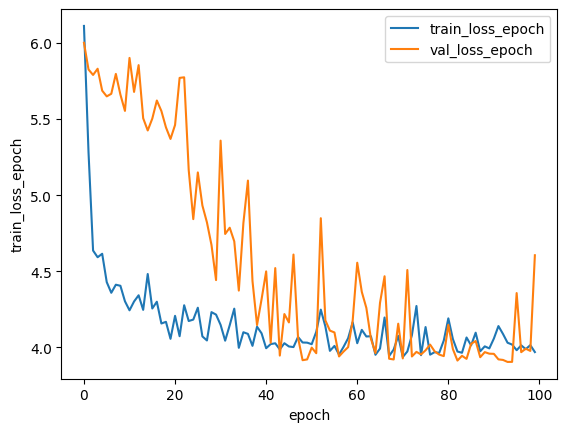

In [2]:
from seaborn import lineplot
import pandas as pd

df = pd.read_csv(PATH_TO_CSV)
lineplot(data=df, x='epoch', y='train_loss_epoch', label='train_loss_epoch')
lineplot(data=df, x='epoch', y='val_loss_epoch', label='val_loss_epoch')

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from minecraft_copilot_ml.data_loader import nbt_to_numpy_minecraft_map

numpy_minecraft_map = nbt_to_numpy_minecraft_map(
    "/home/mehdi/minecraft-copilot-ml/minecraft_schematics/210.schematic"
)
map_unique_values = np.unique(numpy_minecraft_map)
unique_dict = {v: i for i, v in enumerate(map_unique_values)}
unique_dict["minecraft:air"] = 0
map_vectorizeds = np.vectorize(unique_dict.get)(numpy_minecraft_map)
displayed_slice = map_vectorizeds[0, :, :]


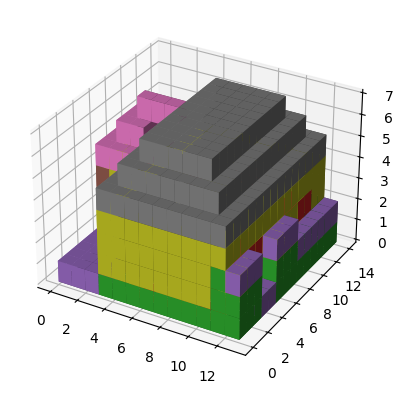

In [4]:
ax = plt.figure().add_subplot(projection="3d")
colors = np.empty(map_vectorizeds.shape, dtype=object)
for i in range(map_vectorizeds.shape[0]):
    for j in range(map_vectorizeds.shape[1]):
        for k in range(map_vectorizeds.shape[2]):
            colors[i, j, k] = f"C{map_vectorizeds[i, j, k]}"
map_vectorizeds = np.transpose(map_vectorizeds, (2, 1, 0))
colors = np.transpose(colors, (2, 1, 0))
ax.voxels(map_vectorizeds, facecolors=colors)
plt.show()

In [5]:
from minecraft_copilot_ml.data_loader import create_noisy_block_map, get_random_block_map_and_mask_coordinates

block_map, (
    random_roll_x_value,
    random_y_height_value,
    random_roll_z_value,
    minimum_width,
    minimum_height,
    minimum_depth,
) = get_random_block_map_and_mask_coordinates(numpy_minecraft_map, 16, 16, 16)
focused_block_map = block_map[
    random_roll_x_value : random_roll_x_value + minimum_width,
    random_y_height_value : random_y_height_value + minimum_height,
    random_roll_z_value : random_roll_z_value + minimum_depth,
]
noisy_focused_block_map = create_noisy_block_map(focused_block_map)
noisy_block_map = block_map.copy()
noisy_block_map[
    random_roll_x_value : random_roll_x_value + minimum_width,
    random_y_height_value : random_y_height_value + minimum_height,
    random_roll_z_value : random_roll_z_value + minimum_depth,
] = noisy_focused_block_map
mask = np.zeros((16, 16, 16), dtype=bool)
mask[
    random_roll_x_value : random_roll_x_value + minimum_width,
    random_y_height_value : random_y_height_value + minimum_height,
    random_roll_z_value : random_roll_z_value + minimum_depth,
] = True

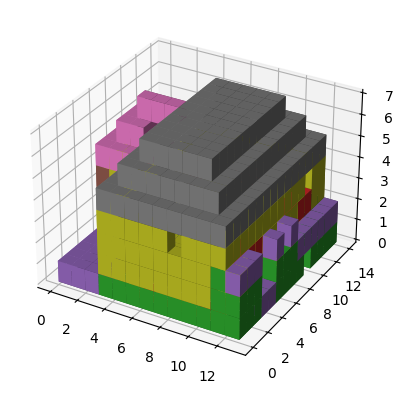

In [6]:
map_vectorizeds = np.vectorize(unique_dict.get)(noisy_focused_block_map)

ax = plt.figure().add_subplot(projection="3d")
colors = np.empty(map_vectorizeds.shape, dtype=object)
for i in range(map_vectorizeds.shape[0]):
    for j in range(map_vectorizeds.shape[1]):
        for k in range(map_vectorizeds.shape[2]):
            colors[i, j, k] = f"C{map_vectorizeds[i, j, k]}"
map_vectorizeds = np.transpose(map_vectorizeds, (2, 1, 0))
colors = np.transpose(colors, (2, 1, 0))
ax.voxels(map_vectorizeds, facecolors=colors)
plt.show()

In [7]:
import torch
import torch.nn.functional as F

model = torch.load(PATH_TO_BEST_MODEL)

In [8]:
pre_processed_noisy_block_map = model.pre_process(np.expand_dims(noisy_block_map, axis=0))

In [9]:
import torch
import torch.nn.functional as F

model = torch.load(PATH_TO_BEST_MODEL)
filled_block_map = model(pre_processed_noisy_block_map).to("cpu")
post_processed: np.ndarray = np.vectorize(model.reverse_unique_blocks_dict.get)(filled_block_map.argmax(dim=1).numpy())


In [10]:
squeezed_post_processed = post_processed[0]

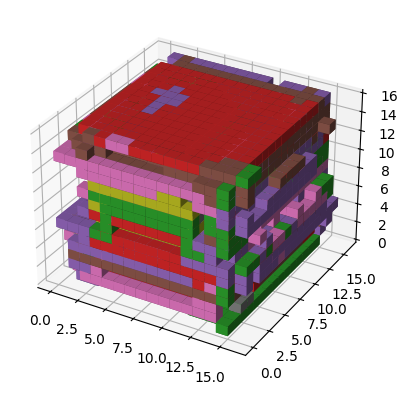

In [11]:
map_vectorizeds = np.vectorize(unique_dict.get)(squeezed_post_processed)

ax = plt.figure().add_subplot(projection="3d")
colors = np.empty(map_vectorizeds.shape, dtype=object)
for i in range(map_vectorizeds.shape[0]):
    for j in range(map_vectorizeds.shape[1]):
        for k in range(map_vectorizeds.shape[2]):
            colors[i, j, k] = f"C{map_vectorizeds[i, j, k]}"
map_vectorizeds = np.transpose(map_vectorizeds, (2, 1, 0))
colors = np.transpose(colors, (2, 1, 0))
ax.voxels(map_vectorizeds, facecolors=colors)
plt.show()